In [1]:
import xgboost as xgb
from xgboost import plot_importance

print(xgb.__version__)

2.0.3


#### 파이썬 Native XGBoost 적용 – 위스콘신 Breast Cancer 데이터 셋

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

diabetes_data = pd.read_csv('diabetes.csv')

print(diabetes_data.describe())
print("\n")

print('데이터 세트 Null 값 갯수 ',diabetes_data.isnull().sum().sum(), "\n")

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

In [3]:
print(diabetes_data.columns)
print(diabetes_data['Outcome'].value_counts())

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Outcome
0    500
1    268
Name: count, dtype: int64


In [4]:
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

diabetes_data.describe()


X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# # StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
# scaler = StandardScaler( )
# X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [5]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환. 
# 학습, 검증, 테스트용 DMatrix를 생성. 
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [6]:
params = { 'max_depth':3,
           'eta': 0.05, # learning-rate
           'objective':'binary:logistic', #iteration
           'eval_metric':'logloss'
        }
num_rounds = 400 # n_estermators

In [7]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다. 
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방. 

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )

[0]	train-logloss:0.61431	eval-logloss:0.76076
[1]	train-logloss:0.60101	eval-logloss:0.74442
[2]	train-logloss:0.58895	eval-logloss:0.73083
[3]	train-logloss:0.57670	eval-logloss:0.71630
[4]	train-logloss:0.56547	eval-logloss:0.70268
[5]	train-logloss:0.55520	eval-logloss:0.69041
[6]	train-logloss:0.54518	eval-logloss:0.68073
[7]	train-logloss:0.53630	eval-logloss:0.67014
[8]	train-logloss:0.52845	eval-logloss:0.66105
[9]	train-logloss:0.52032	eval-logloss:0.65395
[10]	train-logloss:0.51281	eval-logloss:0.64577
[11]	train-logloss:0.50636	eval-logloss:0.63919
[12]	train-logloss:0.49915	eval-logloss:0.62999
[13]	train-logloss:0.49227	eval-logloss:0.62335
[14]	train-logloss:0.48589	eval-logloss:0.61734
[15]	train-logloss:0.47988	eval-logloss:0.61001
[16]	train-logloss:0.47481	eval-logloss:0.60642
[17]	train-logloss:0.46946	eval-logloss:0.59986
[18]	train-logloss:0.46496	eval-logloss:0.59760
[19]	train-logloss:0.46009	eval-logloss:0.59349
[20]	train-logloss:0.45531	eval-logloss:0.58873
[2

In [8]:
# predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3), "\n")

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.433 0.493 0.048 0.562 0.004 0.904 0.906 0.119 0.818 0.013] 

예측값 10개만 표시: [0, 0, 0, 1, 0, 1, 1, 0, 1, 0]


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[84 13]
 [28 29]]
정확도: 0.7338, 정밀도: 0.6905, 재현율: 0.5088,    F1: 0.5859, AUC:0.8123


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

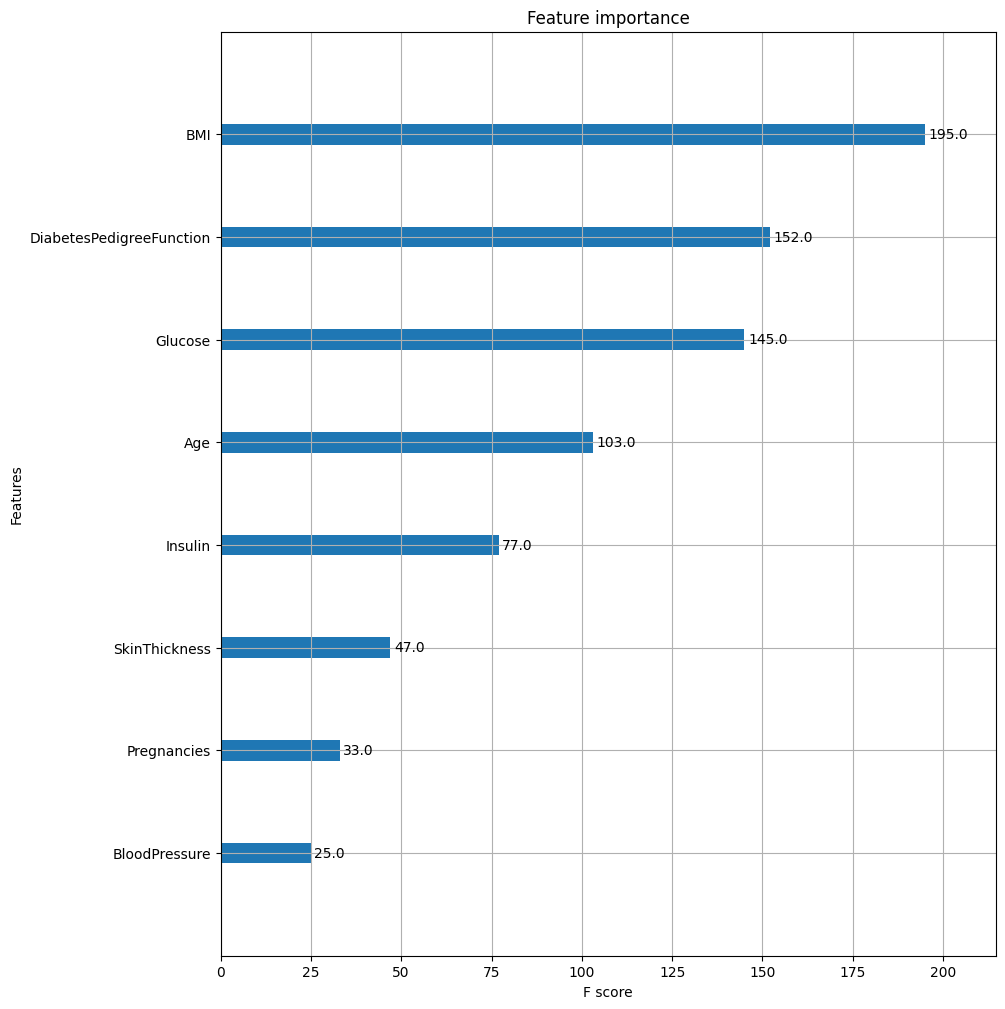

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax) # ax가 그림을 그린다.

#### 사이킷런 Wrapper XGBoost 개요 및 적용

In [11]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력. 미 입력해도 수행에 문제 없음.   
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [12]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[81 16]
 [23 34]]
정확도: 0.7468, 정밀도: 0.6800, 재현율: 0.5965,    F1: 0.6355, AUC:0.8027


In [13]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", # 학습할 때 early_stopping 적용
                eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61431	validation_1-logloss:0.76076
[1]	validation_0-logloss:0.60101	validation_1-logloss:0.74442
[2]	validation_0-logloss:0.58895	validation_1-logloss:0.73083
[3]	validation_0-logloss:0.57670	validation_1-logloss:0.71630
[4]	validation_0-logloss:0.56547	validation_1-logloss:0.70268
[5]	validation_0-logloss:0.55520	validation_1-logloss:0.69041
[6]	validation_0-logloss:0.54518	validation_1-logloss:0.68073
[7]	validation_0-logloss:0.53630	validation_1-logloss:0.67014
[8]	validation_0-logloss:0.52845	validation_1-logloss:0.66105
[9]	validation_0-logloss:0.52032	validation_1-logloss:0.65395
[10]	validation_0-logloss:0.51281	validation_1-logloss:0.64577
[11]	validation_0-logloss:0.50636	validation_1-logloss:0.63919
[12]	validation_0-logloss:0.49915	validation_1-logloss:0.62999
[13]	validation_0-logloss:0.49227	validation_1-logloss:0.62335
[14]	validation_0-logloss:0.48589	validation_1-logloss:0.61734
[15]	validation_0-logloss:0.47988	validation_1-logloss:0.61001
[1

/opt/homebrew/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [14]:
get_clf_eval(y_test , ws50_preds, ws50_pred_proba)

오차 행렬
[[83 14]
 [30 27]]
정확도: 0.7143, 정밀도: 0.6585, 재현율: 0.4737,    F1: 0.5510, AUC:0.8093


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

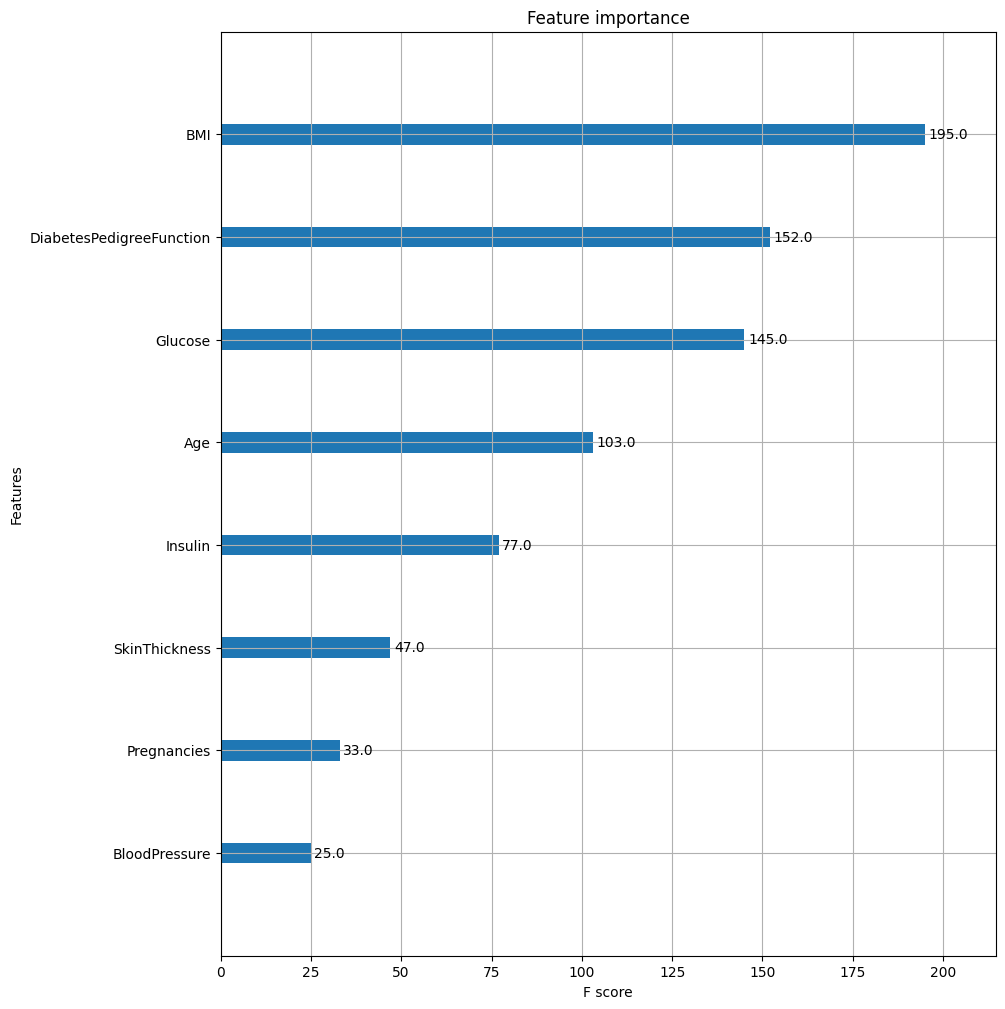

In [15]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)